In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame

from numpy import dstack

import copy

import os
from glob import glob

from path import Path

from numpy import mean
from numpy import std

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import SimpleRNN

from keras.layers import Bidirectional

from keras.utils.vis_utils import plot_model

from keras.callbacks import EarlyStopping

from keras.optimizers import Adam

import random

from sklearn.model_selection import train_test_split

from matplotlib import pyplot

Using TensorFlow backend.


## Load Data

In [2]:
from helpers.classes.data_loader import DataLoader

In [3]:
%%time
root_path = "/home/ubuntu/pose-estimation-jupyter/augmented-keypoints-339"

sample_dir_names = [n for n in os.listdir(root_path) if os.path.isdir(f"{root_path}/{n}")]

samples = DataLoader.get_samples_list(sample_dir_names, root_path)

y_labels = DataLoader.get_y_labels(sample_dir_names) # classifier labels, where 0 = backflip and 1 = flack

Loading frames for 0/339
Loading frames for 1/339
Loading frames for 2/339
Loading frames for 3/339
Loading frames for 4/339
Loading frames for 5/339
Loading frames for 6/339
Loading frames for 7/339
Loading frames for 8/339
Loading frames for 9/339
Loading frames for 10/339
Loading frames for 11/339
Loading frames for 12/339
Loading frames for 13/339
Loading frames for 14/339
Loading frames for 15/339
Loading frames for 16/339
Loading frames for 17/339
Loading frames for 18/339
Loading frames for 19/339
Loading frames for 20/339
Loading frames for 21/339
Loading frames for 22/339
Loading frames for 23/339
Loading frames for 24/339
Loading frames for 25/339
Loading frames for 26/339
Loading frames for 27/339
Loading frames for 28/339
Loading frames for 29/339
Loading frames for 30/339
Loading frames for 31/339
Loading frames for 32/339
Loading frames for 33/339
Loading frames for 34/339
Loading frames for 35/339
Loading frames for 36/339
Loading frames for 37/339
Loading frames for 38/

Loading frames for 308/339
Loading frames for 309/339
Loading frames for 310/339
Loading frames for 311/339
Loading frames for 312/339
Loading frames for 313/339
Loading frames for 314/339
Loading frames for 315/339
Loading frames for 316/339
Loading frames for 317/339
Loading frames for 318/339
Loading frames for 319/339
Loading frames for 320/339
Loading frames for 321/339
Loading frames for 322/339
Loading frames for 323/339
Loading frames for 324/339
Loading frames for 325/339
Loading frames for 326/339
Loading frames for 327/339
Loading frames for 328/339
Loading frames for 329/339
Loading frames for 330/339
Loading frames for 331/339
Loading frames for 332/339
Loading frames for 333/339
Loading frames for 334/339
Loading frames for 335/339
Loading frames for 336/339
Loading frames for 337/339
Loading frames for 338/339
CPU times: user 1min 17s, sys: 1.9 s, total: 1min 19s
Wall time: 1min 36s


In [4]:
i = 5

# Print some sample dir names
a = [print(sample_dir_name) for sdn_i, sample_dir_name in enumerate(sample_dir_names) if sdn_i < i]
a = [print(y_label) for y_i, y_label in enumerate(y_labels) if y_i < i]

backflip-33-mario-aug-2
backflip-46-dagne-aug-1
backflip-63-allar-aug-1
backflip-47-dagne-aug-1
flack-56-martin-aug-0
0
0
0
0
1


## Data padding

In [5]:
from helpers.classes.padder import Padder

In [6]:
%%time
padded_samples_list = Padder.get_padded_samples(samples)
categorical_y_labels = DataLoader.get_categorical_y_labels(y_labels)

padded_samples_ndarray = np.asarray(padded_samples_list)
categorical_y_labels_ndarray = np.asarray(categorical_y_labels)

y_labels_stacked shape: (1, 1, 339)
y_labels_categorical shape: (1, 1, 339, 2)
y_labels_squeezed shape (339, 2)
y_label categorical: [1.0, 0.0]
y_label categorical: [1.0, 0.0]
y_label categorical: [1.0, 0.0]
y_label categorical: [1.0, 0.0]
y_label categorical: [0.0, 1.0]
CPU times: user 3.68 s, sys: 20.1 ms, total: 3.7 s
Wall time: 3.67 s


## Build model

In [43]:
def get_simple_lstm_model(lstm_units, n_outputs, n_features, n_timesteps):
    optimizer = Adam(lr=0.005)
        
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(n_timesteps, n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(lstm_units, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model

def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs = 1, 5
        
    lstm_units = 2

    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = get_simple_lstm_model(lstm_units, n_outputs, n_features, n_timesteps)
    
    
    print(model.summary())
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    
    batch_size = 1
    
    es_callback = EarlyStopping(monitor='val_loss', patience=4)
    
    history = model.fit(trainX,
                        trainy,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=verbose,
                        validation_split=0.33,
                        callbacks=[es_callback])
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    # fit network
    #model.fit_generator(train_generator(trainX, trainy), steps_per_epoch=n_steps_per_epoch, epochs=epochs, verbose=verbose)
    # evaluate model
    #_, accuracy = model.evaluate_generator(train_generator(testX, testy), steps=len(testX), verbose=0)
    
    return history, accuracy, model

In [44]:
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [45]:
def save_model(model, repeat):
    # serialize model to JSON
    model_json = model.to_json()
    with open(f"model-{repeat}.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"model-{repeat}.h5")
    print("Saved model to disk")

## Run experiment

In [49]:
X_train, X_test, y_train, y_test = train_test_split(padded_samples_ndarray,
                                                    categorical_y_labels_ndarray,
                                                    test_size=0.2,
                                                    random_state=42)

print(f"X train len: {len(X_train)}, y train len:{len(y_train)} --- X test len:{len(X_test)}, y test len:{len(y_test)}")

train_loss_history = DataFrame()
val_loss_history = DataFrame()

train_accuracy_history = DataFrame()
val_accuracy_history = DataFrame()

model_history = []

# run an experiment
def run_experiment(repeats=5):
    # repeat experiment
    scores = list()
    last_history = None
    
    for r in range(repeats):
        history, score, model = evaluate_model(X_train, y_train, X_test, y_test)
        #model, score = evaluate_model(UtrainX, Utrainy, UtestX, Utesty)
        
        model_history.append(model)
        save_model(model, r)
        
        # story history
        train_loss_history[str(r)] = history.history['loss']
        val_loss_history[str(r)] = history.history['val_loss']
        train_accuracy_history[str(r)] = history.history['accuracy']
        val_accuracy_history[str(r)] = history.history['val_accuracy']
        
        score = score * 100.0
        print('>#%d validation accuracy: %.3f' % (r+1, score))
        scores.append(score)
        
    # summarize results
    summarize_results(scores)

X train len: 271, y train len:271 --- X test len:68, y test len:68


In [52]:
%%time
run_experiment()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 2)                 264       
_________________________________________________________________
dropout_41 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_81 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_82 (Dense)             (None, 2)                 6         
Total params: 276
Trainable params: 276
Non-trainable params: 0
_________________________________________________________________
None
Train on 181 samples, validate on 90 samples
Epoch 1/5
181/181 [==============================] - 29s 163ms/step - loss: 0.6583 - accuracy: 0.5967 - val_loss: 0.6864 - val_accuracy: 0.4889
Epoch 2/5
181/181 [==============================] - 29s 16

181/181 [==============================] - 29s 159ms/step - loss: 0.4596 - accuracy: 0.8508 - val_loss: 0.2160 - val_accuracy: 0.9667
Epoch 5/5
181/181 [==============================] - 28s 156ms/step - loss: 0.3801 - accuracy: 0.8453 - val_loss: 0.1840 - val_accuracy: 0.9667
Saved model to disk
>#5 validation accuracy: 97.059
[80.88235259056091, 100.0, 95.58823704719543, 100.0, 97.0588207244873]
Accuracy: 94.706% (+/-7.120)
CPU times: user 25min 54s, sys: 3min 40s, total: 29min 34s
Wall time: 12min 7s


## Gradients

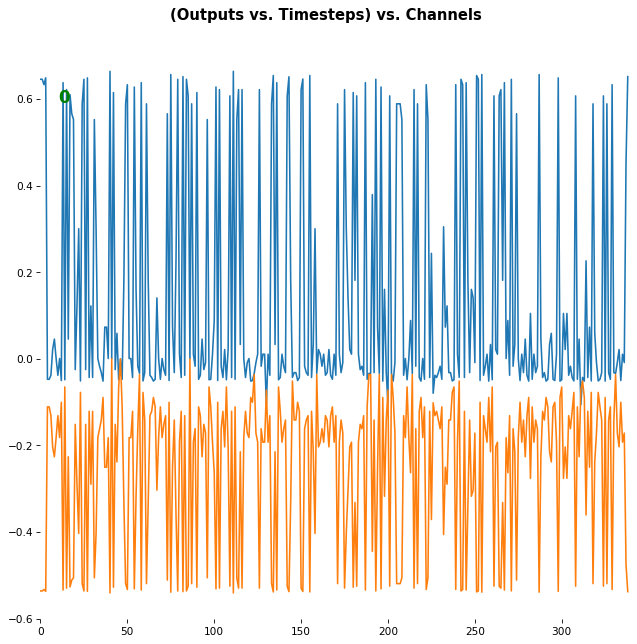

In [71]:
from see_rnn import get_gradients, get_outputs, get_rnn_weights
from see_rnn import features_0D, features_1D, features_2D
from see_rnn import rnn_heatmap, rnn_histogram


x = padded_samples_ndarray


def viz_outs(model, idx=1):
    outs = get_outputs(model, idx, x)
    
    features_1D(outs, n_rows=8, show_borders=False)
    #features_2D(outs,     n_rows=8, norm=(-1,1))
    
model = model_history[1]

viz_outs(model, 1)
#viz_outs_grads(model, 1)

#data = get_rnn_weights(model, 1)
#viz_prefetched_data(model, data, 1)

## Plots

In [65]:
model_num = '5'
model_num_for_fig = int(model_num) + 1

pyplot.plot(train_loss_history[model_num], color='blue', label='train')
pyplot.plot(val_loss_history[model_num], color='orange', label='validation')
pyplot.title(f"LSTM model {model_num_for_fig} train vs validation loss")
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
#pyplot.show()

fig_name = f"model-output/model-{model_num_for_fig}-train-vs-validation-loss.png"
pyplot.savefig(fig_name)

KeyError: '5'

In [66]:
pyplot.plot(train_accuracy_history[model_num], color='blue', label='train')
pyplot.plot(val_accuracy_history[model_num], color='orange', label='validation')
pyplot.title(f"LSTM model {model_num_for_fig} train vs validation accuracy")
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
#pyplot.show()

fig_name = f"model-output/model-{model_num_for_fig}-train-vs-validation-accuracy.png"
pyplot.savefig(fig_name)

KeyError: '5'